In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [3]:
# Load the dataset
data = pd.read_csv("Tweets.csv")

In [4]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


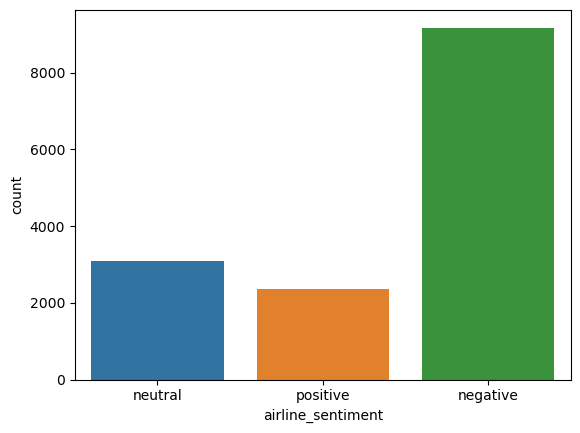

In [5]:
sns.countplot(x='airline_sentiment', data=data)
plt.show()

<Axes: >

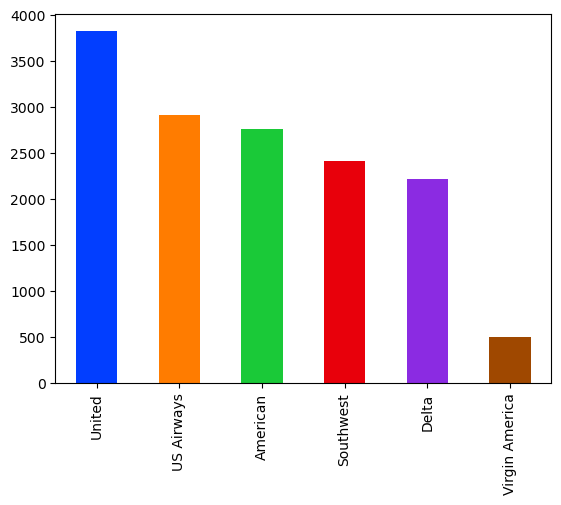

In [6]:
data['airline'].value_counts().plot(kind="bar",color=sns.color_palette('bright'))

<Axes: xlabel='airline'>

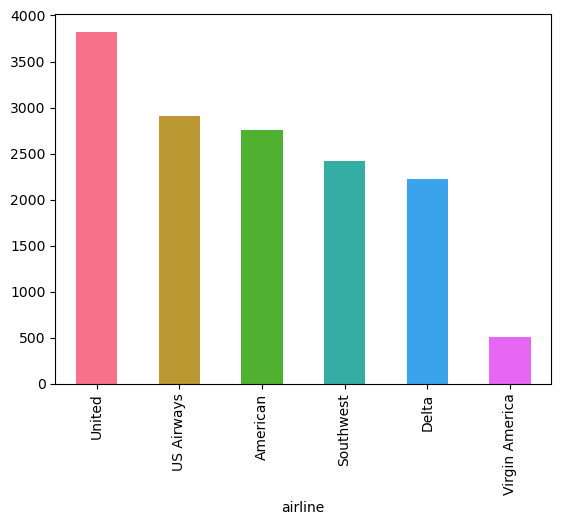

In [7]:
data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar',color=sns.color_palette('husl'))

In [8]:
# Text preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

data['clean_text'] = data['text'].apply(preprocess_text)
data['clean_text']

0                                                     said
1            plus youve added commercials experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minutes late flight warnings communica...
14637            please bring american airlines blackberry
14638    money change flight dont answer phones suggest...
14639    ppl need know many seats next flight plz put u...
Name: clean_text, Length: 14640, dtype: object

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['airline_sentiment'], test_size=0.2, random_state=42)

In [10]:
# Model selection and training
models = [
    ('Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Support Vector Machine', SVC()),
    ('Ada Boost', AdaBoostClassifier())
]

In [11]:
best_model = None
best_accuracy = 0

for name, model in models:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline
        best_model_name = name
        
print(best_model_name)

Model: Naive Bayes
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1889
     neutral       0.74      0.16      0.26       580
    positive       0.91      0.23      0.37       459

    accuracy                           0.71      2928
   macro avg       0.78      0.46      0.48      2928
weighted avg       0.74      0.71      0.64      2928

[[1875   13    1]
 [ 479   92    9]
 [ 335   19  105]]
Accuracy: 0.7076502732240437
Model: Logistic Regression
              precision    recall  f1-score   support

    negative       0.81      0.95      0.88      1889
     neutral       0.68      0.44      0.54       580
    positive       0.82      0.63      0.71       459

    accuracy                           0.80      2928
   macro avg       0.77      0.67      0.71      2928
weighted avg       0.79      0.80      0.78      2928

[[1790   71   28]
 [ 289  256   35]
 [ 121   48  290]]
Accuracy: 0.7978142076502732
Model: Random Forest
   

In [12]:
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'model__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Best Parameters: {'model__C': 1, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2)}


In [13]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model: {best_model['model']}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")

Model: LogisticRegression(C=1, max_iter=1000)
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1889
     neutral       0.66      0.48      0.55       580
    positive       0.80      0.62      0.70       459

    accuracy                           0.79      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928

[[1759   97   33]
 [ 264  278   38]
 [ 126   49  284]]
Accuracy: 0.792691256830601


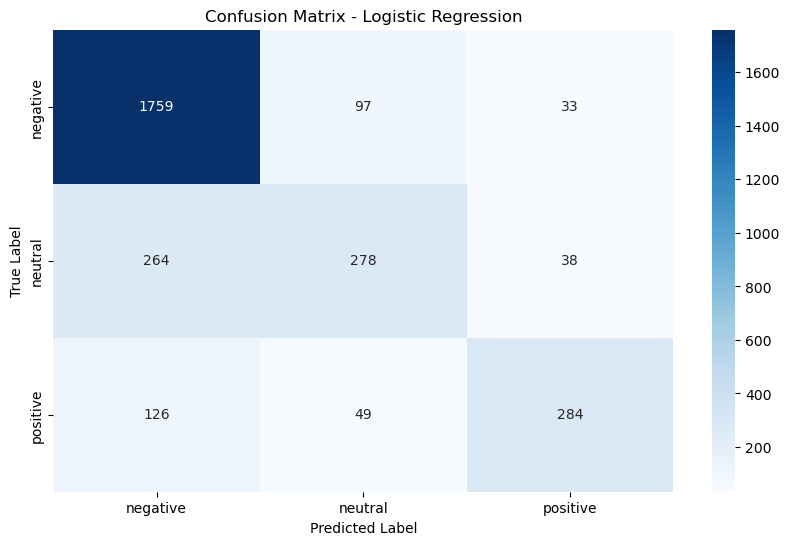

In [14]:
# Visualization of the best model's performance
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

In [15]:
# Try one input example
input_example = "The flight was great! Loved the service and the food."
input_example_clean = preprocess_text(input_example)
predicted_sentiment = best_model.predict([input_example_clean])[0]
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: positive


In [16]:
# Try one input example
input_example = "The flight was bad! Hated the service and the food."
input_example_clean = preprocess_text(input_example)
predicted_sentiment = best_model.predict([input_example_clean])[0]
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: negative


In [17]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']